# Efficient Global Optimization employing Deep Gaussian Process Regression

See DGPR implementations in:

https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html
https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/KISSGP_Deep_Kernel_Regression_CUDA.html

In [3]:
import numpy as np

from scipy.stats import qmc
from scipy.special import erf
import scipy.io as sio

import torch
from torch.nn import Sequential, Linear, ReLU, init
from torch.nn.utils import spectral_norm
from torch.optim import Adam

from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.utils.grid import ScaleToBounds
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.settings import use_toeplitz, fast_pred_var
from gpytorch.constraints.constraints import GreaterThan

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

from bsa import bsa

In [5]:
from ansys.mapdl.core import launch_mapdl
def launch_mapdl_on_available_port(starting_port=50052, max_attempts=10):
    for i in range(max_attempts):
        port = starting_port + i
        try:
            mapdl = launch_mapdl(port=port)
            print(f"MAPDL launched successfully on port {port}")
            return mapdl
        except Exception as e:
            print(f"Failed to launch MAPDL on port {port}: {e}")
    raise RuntimeError("Could not launch MAPDL on any available port")

# Use a função para iniciar uma instância do MAPDL
mapdl = launch_mapdl_on_available_port()

Failed to launch MAPDL on port 50052: The port 50052 is already being used.
Failed to launch MAPDL on port 50053: The port 50053 is already being used.
Failed to launch MAPDL on port 50054: The port 50054 is already being used.
Failed to launch MAPDL on port 50055: The port 50055 is already being used.
Failed to launch MAPDL on port 50056: The port 50056 is already being used.
Failed to launch MAPDL on port 50057: The port 50057 is already being used.
Failed to launch MAPDL on port 50058: The port 50058 is already being used.
Failed to launch MAPDL on port 50059: The port 50059 is already being used.
MAPDL launched successfully on port 50060


In [6]:
# Set the seed for reproducibility
seed = 42 # CHANGE SEED IN EACH DIFFERENT INDEPENDENT RUN!

# For NumPy
np.random.seed(seed)

# For PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU

# For Python's built-in random module
random.seed(seed)

# Ensuring reproducibility in cuDNN using PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## *GPR Model*

### Gaussian Process Regression

In [7]:
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())
        self.scale_to_bounds = ScaleToBounds(-1., 1.)
        
        # Store train_y for later use
        self.train_outputs = train_y

    def forward(self, x):
        projected_x = self.scale_to_bounds(x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return MultivariateNormal(mean_x, covar_x)


### Train model

In [8]:
def train_model(train_x, train_g, val_x, val_g, training_iterations):
    # Initialize the models and likelihood
    likelihood = GaussianLikelihood()
    model = GPRegressionModel(train_x=train_x, train_y=train_g, likelihood=likelihood)

    # if torch.cuda.is_available():
    #     model = model.cuda()
    #     likelihood = likelihood.cuda()

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = Adam([
        {'params': model.covar_module.parameters()},
        {'params': model.mean_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=0.005)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # To track loss values
    training_losses = []
    validation_losses = []

    # Training loop with validation
    def train():
        best_loss, best_val_loss, best_train_loss = 1e4, 1e4, 1e4
        patience = int(training_iterations * 0.1)
        wait = 0

        for epoch in range(training_iterations):
            model.train()
            likelihood.train()

            # Zero backprop gradients
            optimizer.zero_grad()

            # Forward pass and calculate loss on training set
            output = model(train_x)
            loss = -mll(output, train_g)
            loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            likelihood.eval()
            with torch.no_grad():
                val_output = model(val_x)
                val_loss = -mll(val_output, val_g).item()

            # Save the best model based on validation and training loss
            training_loss = loss.item()
            final_loss = val_loss # val_loss*0.5 + training_loss*0.5
 
            if final_loss < best_loss:
                best_loss = final_loss
                best_val_loss = val_loss
                best_train_loss = training_loss
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_model_GPR.pth')
                wait = 0  # Reset patience counter when improvement is found
            else:
                wait += 1  # Increment patience counter if no improvement

            # Early stopping
            if wait > patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

            # Track losses for plotting
            training_losses.append(loss.item())
            validation_losses.append(val_loss)

            # print(f'Epoch {epoch + 1} - Training Loss: {loss.item()} - Validation Loss: {val_loss}')

        print(f'Best Loss: {best_loss} at epoch {best_epoch}. Training loss: {best_train_loss} and val. loss: {best_val_loss}')
        return best_val_loss, best_train_loss
    best_loss = train()

    # Load the best model state
    model.load_state_dict(torch.load('best_model_GPR.pth'))

    # Set model and likelihood to eval mode for further evaluation
    model.eval()
    likelihood.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, likelihood, best_loss


## Initial sampling plan (Latin Hypercube sampling)

In [9]:
def LHS_sample(num_points, DIM):
    # Number of variables and sampling points
    size = int(num_points)

    # Generate LHS samples
    sampler = qmc.LatinHypercube(d=DIM,
                                 optimization="random-cd")
    lhs_sample = sampler.random(n=size)

    return lhs_sample

## Expected Improvement

In [10]:
def expected_improvement(x, model):
    """
    Function to calculate the Expected Improvement using Monte Carlo Integration.
    
    Parameters:
        x (array): Individual under evaluation.
        y (array): Valor mínimo obtido até o momento.
    
    Returns:
        array: The value of the Expected Improvement.
    """
    # Get the minimum value obtained so far
    ymin = torch.min(model.train_outputs)
    # ymin = torch.Tensor(ymin)

    # Calculate the prediction value and the variance (Ssqr)
    with torch.no_grad(), use_toeplitz(False), fast_pred_var():
        preds = model(x)
    f = preds.mean
    s = preds.variance

    # Check for any errors that are less than zero (due to numerical error)
    s[s < 0] = 0  # Set negative variances to zero

    # Calculate the RMSE (Root Mean Square Error)
    s = torch.sqrt(s)

    # Calculation of Expected Improvement
    term1 = (ymin - f) * (0.5 + 0.5 * erf((ymin - f) / (s * torch.sqrt( torch.from_numpy(np.array([2])) ))))
    term2 = (1 / torch.sqrt(2 * torch.from_numpy(np.array([np.pi])))) * s * torch.exp(-((ymin - f) ** 2) / (2 * s ** 2))
    
    return -(term1 + term2)

## Define the problem

### Parameters of the optimization

In [11]:
TRAINING_ITERATIONS = 20000 # epochs for training the GPR
N_INITIAL = 50  # initial number of points
N_INFILL = 100  # number of infill points
BSA_POPSIZE = 50
BSA_EPOCH = 20000

### Set variables

In [12]:
DIM = 11 # dimension of your problem (number of design variables)
BOUNDS_BSA = (
    tuple((0, 1) for _ in range(DIM)) # the number of (0, 1) tuples has to be equal to DIM
    )

### Objective function

Your objective function must go inside obj_fun. The input is *xx*, your design variables vector, and the output is the objective function value (your own cost function).

You can either import your objective function from a *.py* file using `import obj_fun from my_file` (where *my_file.py* contains your objective function that is called *obj_fun*, already organized to receive a design variable vector (or matrix) as input and output an objective function value) or just replace the *obj_fun* code below by your entire code.

In [26]:
import math
import numpy as np 
import pandas as pd

# Definindo variáveis apenas uma vez
raio_estaca = 0.5
distancia_minima = raio_estaca * 2.5  # 5 vezes o raio da estaca
largura = 6
altura = 3
n_estacas = 2
n_estacas_centrais = round(1) 
L_estacas=20

#FUNÇÕES AUXILIARES
def round_to_nearest(value, targets=[0, 0.333, 0.666, 1]): #Arrendonda o valor de angulo vertical para o valor mais próximo a fim de trabalhar dentro de limites construtivos de equipamento e também trabalhar com um menor espaço amostral                    
    return min(targets, key=lambda t: abs(value - t))

def distancia_entre_pontos(p1, p2): #Mede a distancia entre pontos a fim de assegurar limites geométricos da estrutura
    return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

def espelhar_pontos(coordinates, n_estacas_centrais): 
    espelho = [(x, -y, z) for x, y, z in coordinates[:-int(n_estacas_centrais)]]
    return espelho

def converter_x(x_normalizado): #Converte os valores do de interesse em coordenadas "X"
    return raio_estaca + x_normalizado * (largura-2*raio_estaca)

def converter_y(y_normalizado): #Converte os valores do de interesse em coordenadas "Y"
    return raio_estaca + y_normalizado * (altura-2*raio_estaca)

def converter_angulos_verticais(array_angulos_verticais): #Converte os valores do de interesse em angulos trigonométricos
    return [np.round(75 + 15 * ang_v, 2) for ang_v in array_angulos_verticais]

def converter_angulos_horizontais(array_angulos_horizontais):
    # Aplica a conversão padrão para ang_h1 e ang_h2 e uma conversão alternativa para ang_h3
    return [
        np.round(46 + 268 * ang_h, 2) if i < n_estacas else np.round(180 * ang_h, 2)
        for i, ang_h in enumerate(array_angulos_horizontais)
    ]

def round_to_binary(value):
    return 1 if value >= 0.5 else 0

def spherical_to_cartesian(x_inicial, y_inicial, z_inicial, L_estacas, angulos_verticais_theta, angulos_horizontais_theta): #Converte os valores do de interesse em coordendas cartesianas
    angulo_vertical_rad = np.deg2rad(angulos_verticais_theta)
    angulo_horizontal_rad = np.deg2rad(angulos_horizontais_theta)
    
    componente_x = L_estacas * np.cos(angulo_vertical_rad) * np.cos(angulo_horizontal_rad)
    componente_y = L_estacas * np.cos(angulo_vertical_rad) * np.sin(angulo_horizontal_rad)
    componente_z = L_estacas * np.sin(angulo_vertical_rad)
    
    x_final = x_inicial + componente_x
    y_final = y_inicial + componente_y
    z_final = z_inicial + componente_z

    return x_final, y_final, z_final

def gerar_pontos_finais(pontos, angulos_verticais_theta, angulos_horizontais_theta): #Gera pontos finais
    coordenadas_finais = []
    for i in range(len(pontos)):
        x, y, z = pontos[i]
        theta_v, theta_h = angulos_verticais_theta[i], angulos_horizontais_theta[i]
        x_final, y_final, z_final = spherical_to_cartesian(x, y, z, L_estacas, theta_v, theta_h)
        coordenadas_finais.append((round(x_final, 2), round(y_final, 2), -1*round(z_final, 2)))
    return coordenadas_finais

def espelhar_pontos_finais(pontos, k):
    espelho = []
    for (x, y, z) in pontos[:-k]:
        y_espelhado = -y
        espelho.append((x, y_espelhado, z))
    return espelho

def distancia_entre_pontos_r3(p1, p2): #Garante limites geométricos/normatívos da estrutura
    return round(np.linalg.norm(p1 - p2), 2)

def encontrar_menor_distancia_entre_vetores(pontos_iniciais, pontos_finais, k, l, comprimento): #Garante limites geométricos/normatívos da estrutura
    vetor_k = pontos_finais[k] - pontos_iniciais[k]
    vetor_l = pontos_finais[l] - pontos_iniciais[l]

    vetor_dividido_k = vetor_k / comprimento
    vetor_dividido_l = vetor_l / comprimento

    menor_distancia = float('inf')
    ponto_menor_distancia_v1 = None
    ponto_menor_distancia_v2 = None
    N_v1 = None
    N_v2 = None

    for N1 in np.arange(1, 19, 1):
        for N2 in np.arange(1, 19, 1):
            ponto_v1 = pontos_iniciais[k] + N1 * vetor_dividido_k
            ponto_v2 = pontos_iniciais[l] + N2 * vetor_dividido_l

            dist = round(distancia_entre_pontos_r3(ponto_v1, ponto_v2), 2)

            if dist < menor_distancia:
                menor_distancia = dist
                ponto_menor_distancia_v1 = ponto_v1
                ponto_menor_distancia_v2 = ponto_v2
                N_v1 = N1
                N_v2 = N2

    return menor_distancia, ponto_menor_distancia_v1, ponto_menor_distancia_v2, N_v1, N_v2

def gerar_lista_k(array_angulos_verticais, n_estacas, n_estacas_centrais): #Gera lista auxiliar
    indices = list(range(len(array_angulos_verticais)))
    indices_menores = sorted(range(len(array_angulos_verticais) - 1), key=lambda i: array_angulos_verticais[i])[:n_estacas]
    lista_k = [i for i in indices_menores]
    lista_k.append(2)
    if len(lista_k) < n_estacas + n_estacas_centrais and lista_k.count(2) < 2:
        lista_k.append(2)
    return lista_k

#Garante limites geométricos/normatívos da estrutura, tentando otimizar brevemente a estrutura, caso não seja possível, penaliza ela
def verificar_e_ajustar_pontos(pontos, L_estacas, distancia_minima, pontos_finais, array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos, array_angulos_horizontais,p):
    max_iteracoes=1*(n_estacas+n_estacas_centrais+n_estacas)
    iteracao = 0
    pontos_finais = np.array(pontos_finais)
    incremento = 0.05
    lista_k = gerar_lista_k(array_angulos_verticais_convertidos, n_estacas, n_estacas_centrais)
    trial=5

    for k in lista_k:
        while iteracao <= max_iteracoes:
            ajustou_ponto = False

            for l in range(len(pontos_finais)):
                if k == l:
                    continue
                ponto1 = pontos_finais[k]
                ponto2 = pontos_finais[l]
                dist = distancia_entre_pontos_r3(ponto1, ponto2)
                menor_distancia, _, _, _, _ = encontrar_menor_distancia_entre_vetores(pontos, pontos_finais, k, l, L_estacas)
                if menor_distancia < 3 * raio_estaca or dist < 5 * raio_estaca:
                    ajustou_ponto = True
                    if k <= n_estacas:
                        array_angulos_horizontais_convertidos[k] = np.round(array_angulos_horizontais_convertidos[k]+incremento,2)
                        array_angulos_horizontais[k] = np.round(array_angulos_horizontais[k]+incremento,2)
                    else:
                        # Alterna entre 0/180 e 0/1 usando (-1)**trial
                        if (-1) ** trial == 1:
                            array_angulos_horizontais_convertidos[k] = 180
                            array_angulos_horizontais[k] = 1
                        else:
                            array_angulos_horizontais_convertidos[k] = 0
                            array_angulos_horizontais[k] = 0

                    x_novo, y_novo, z_novo = spherical_to_cartesian(
                        pontos[k][0], pontos[k][1], pontos[k][2],
                        L_estacas, array_angulos_verticais_convertidos[k], array_angulos_horizontais_convertidos[k]
                    )
                    x = np.round(x_novo, 2)
                    y = np.round(y_novo, 2)
                    z = -1*np.round(z_novo, 2)

                    if k < n_estacas:
                        pontos_finais[k, :] = [x, y, z]
                        pontos_finais[k + n_estacas + n_estacas_centrais, :] = [x, -y, z]
                    else:
                        pontos_finais[k, :] = [x, y, z]
                    break

            if not ajustou_ponto:
                break
            trial += 1
            
            if trial >= max_iteracoes:
                p+= ((3 * raio_estaca)/(0.1+menor_distancia)+(5 * raio_estaca)/(0.1+dist))
                k+=1
                iteracao+=1

                break

    return pontos_finais, array_angulos_horizontais_convertidos, array_angulos_horizontais,p

def analise(pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais):#Analise estrutural dentro do ansys
    mapdl.clear('NOSTART')
    mapdl.prep7()

    # Título
    mapdl.title('Análise de Estacas e Casca')

    # Definir o tipo de elemento (BEAM188) e suas propriedades
    mapdl.et(1, 'BEAM188')

    # Propriedades do material
    modulo_elasticidade = 0.85 * 5600 * (40 ** 0.5) * 1e6  # N/m²
    mapdl.mp('EX', 1, modulo_elasticidade)
    mapdl.mp('PRXY', 1, 0.2)  # Coeficiente de Poisson
    mapdl.mp('DENS', 1, 2500)  # Densidade

    # Propriedades da seção da viga
    mapdl.sectype(1, 'BEAM', 'CSOLID')
    mapdl.secoffset('CENT')
    mapdl.secdata(0.5)

    # Número de nós intermediários
    num_intermediate_nodes = 9

    # Adicionar nós
    node_id = 1
    for i in range(2 * n_estacas + n_estacas_centrais):
        # Obter coordenadas iniciais e finais
        x_inicial, y_inicial, z_inicial = pontos_iniciais[i]
        x_final, y_final, z_final = pontos_finais_ajustados[i]

        # Criar o nó inicial
        mapdl.n(node_id, x_inicial, y_inicial, z_inicial)

        # Definir o ID do nó final
        node_id_final = node_id + num_intermediate_nodes + 1

        # Criar o nó final
        mapdl.n(node_id_final, x_final, y_final, z_final)

        # Travar o nó final
        mapdl.d(node_id_final, 'ALL', 0)

        # Preencher nós intermediários
        mapdl.fill(node_id, node_id_final, num_intermediate_nodes)

        # Atualizar o próximo node_id
        node_id = node_id_final + 1

    # Geração de elementos
    n_elemento = 1
    for i in range(2 * n_estacas + n_estacas_centrais):
        for j in range(1, num_intermediate_nodes + 2):
            N_1 = j + (num_intermediate_nodes + 2) * i
            N_2 = N_1 + 1
            mapdl.en(n_elemento, N_1, N_2)
            n_elemento += 1

    # Selecionar elementos tipo BEAM188
    mapdl.esel('S', 'TYPE', '', 1)

    # Contar elementos selecionados
    num_elem = mapdl.get('num_elem', 'ELEM', 0, 'COUNT')
    k = num_elem

    # Criar elemento de carga
    mapdl.n(1000, 3, 0, 0)
    mapdl.n(1001, 3, 0, 0.1)
    mapdl.en(k + 1, 1000, 1001)

    # Definir tipo de elemento SHELL181
    mapdl.et(2, 'SHELL181')
    mapdl.keyopt(2, 8, 2)  # Elastoplástico
    mapdl.keyopt(2, 3, 2)  # Precisão de tensões

    # Propriedades do material para SHELL181
    modulo_elasticidade_shell = 0.85 * 5600 * (20 ** 0.5) * 1e6
    mapdl.mp('EX', 2, modulo_elasticidade_shell)
    mapdl.mp('PRXY', 2, 0.2)
    mapdl.mp('DENS', 2, 2500)

    # Definir seção de casca
    mapdl.sectype(2, 'SHELL')
    mapdl.secdata(1.5)

    # Criar retângulo e malhar
    mapdl.rectng(0, 6, -3, 3)
    mapdl.esize(0.1)
    mapdl.amesh('ALL')

    # Selecionar elementos tipo SHELL181
    mapdl.esel('S', 'TYPE', '', 2)
    mapdl.emodif('ALL', 'SECNUM', 2)

    # Merge de nós
    mapdl.nsel('S', 'LOC', 'Z', 0, 1e5)
    mapdl.nummrg('NODE', 1e-5)
    mapdl.nsel('ALL')

    # Saída dos resultados
    mapdl.allsel('ALL')

    # Aplicar gravidade
    mapdl.acel(0, 0, -9.81)

    # Finalizar
    mapdl.finish()

    # Entrar no modo de solução
    mapdl.slashsolu()
    mapdl.antype(0)

    # Definir a força aplicada e o número de load steps
    f = 1000000  # Força de 1 milhão de N
    casos = 12  # Definir loadsteps

    # Loop para aplicar as diferentes condições de carga (12 casos de 15 em 15 graus)
    for i in range(1, casos + 2):
        Rad = (i - 1) * (180 / casos) * math.pi / 180  # Variação de 15 graus

        # Calcular as componentes da força horizontal
        FX = math.cos(Rad) * f
        FY = math.sin(Rad) * f

        # Selecionar todos os elementos
        mapdl.allsel('ALL')

        # Aplicar as forças horizontais no nó 1001
        mapdl.f(1001, 'FX', FX)
        mapdl.f(1001, 'FY', FY)

        # Resolver o modelo
        mapdl.solve()

        # Salvar os resultados da solução
        mapdl.save(f'load_step_{i}')

    # Finalizar a análise
    mapdl.finish()

    # Definir o número de casos
    casos = 12

    # Entrar no modo de pós-processamento
    mapdl.post1()

    # Definir os Load Cases para N = 12
    for i in range(1, casos + 2):
        mapdl.lcdef(i, i, 1)  # Define o Load Case i para o Load Step i

    # Carregar o primeiro Load Case
    mapdl.lcase(1)

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO MAX!!!!!!!!!!!!!!!!!!!!!
    # Comparar o Load Case 1 com os demais e armazenar os resultados (máximos)
    for R in range(2, casos + 2):
        mapdl.lcoper('MAX', R)  # Compara o Load Case na memória com os próximos
        mapdl.lcwrite(50 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(50 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('Fx_MAX', 'SMISC', 1, 'MAX')  # Força Axial máxima

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO MIN!!!!!!!!!!!!!!!!!!!!!
    # Carregar o primeiro Load Case novamente
    mapdl.lcase(1)

    # Comparar o Load Case 1 com os demais para valores mínimos
    for R in range(2, casos + 2):
        mapdl.lcoper('MIN', R)  # Compara o Load Case na memória para valores mínimos
        mapdl.lcwrite(60 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(60 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('Fx_MIN', 'SMISC', 1, 'MIN')  # Força Axial mínima

    #!!!!!!!!!!!!!!!!!!!!!CÁLCULO DO ABSMAX!!!!!!!!!!!!!!!!!!!!!
    # Carregar o primeiro Load Case
    mapdl.lcase(1)

    # Comparar o Load Case 1 com os demais e armazenar os resultados (máximos absolutos)
    for R in range(2, casos + 2):
        mapdl.lcoper('ABMX', R)  # Compara o Load Case na memória com os próximos
        mapdl.lcwrite(50 + R)   # Escreve o resultado em um arquivo

    mapdl.lcase(50 + (casos + 1))  # Carregar o último load case comparado
    mapdl.etable('My_ABMX', 'SMISC', 2, 'ABMX')  # Momento fletor máximo em Y
    mapdl.etable('Mz_ABMX', 'SMISC', 3, 'ABMX')  # Momento fletor máximo em Z

    # Gerar ETABLE para deslocamentos dos nós selecionados
    mapdl.etable('UX', 'U', 'X')  # Deslocamento em X
    mapdl.etable('UY', 'U', 'Y')  # Deslocamento em Y
    mapdl.etable('UZ', 'U', 'Z')  # Deslocamento em Z

    # Definir a sequência de elementos
    elementos_sequencia = []
    j = 1
    for i in range(0, (2 * n_estacas) + n_estacas_centrais, 1):
        y = num_intermediate_nodes * i + j
        elementos_sequencia.append(y)
        j += 1

    # Dicionário para armazenar os resultados
    data = {
        "Fx_MAX": [],
        "Fx_MIN": [],
        "Utot": [],
        "My": [],
        "Mz": [],
        "r_max": [],
        "load_case_max": []
    }

    # Primeiro loop: Calculando Fx_MAX, Fx_MIN e Utot para cada elemento
    for elem in elementos_sequencia:
        fx_max = mapdl.get_value('ELEM', elem, 'ETABLE', 'Fx_MAX') / 1000  # kN
        fx_min = mapdl.get_value('ELEM', elem, 'ETABLE', 'Fx_MIN') / 1000  # kN
        ux = mapdl.get_value('ELEM', elem, 'ETABLE', 'UX') * 1000  # mm
        uy = mapdl.get_value('ELEM', elem, 'ETABLE', 'UY') * 1000  # mm
        uz = mapdl.get_value('ELEM', elem, 'ETABLE', 'UZ') * 1000  # mm
        Utot = math.sqrt(ux**2 + uy**2 + uz**2)

        # Adicionando os valores calculados ao dicionário
        data["Fx_MAX"].append(fx_max)
        data["Fx_MIN"].append(fx_min)
        data["Utot"].append(Utot)

    # Segundo loop: Calculando r_max, My, e Mz para cada elemento em todos os load cases
    for elem in elementos_sequencia:
        r_max_elem = 0
        my_max_elem = 0
        mz_max_elem = 0
        load_case_max = 0

        for load_case in range(1, casos + 2):
            mapdl.lcase(load_case)

            mapdl.etable('My', 'SMISC', 2)
            mapdl.etable('Mz', 'SMISC', 3)

            my_val = mapdl.get_value('ELEM', elem, 'ETABLE', 'My') / 1000
            mz_val = mapdl.get_value('ELEM', elem, 'ETABLE', 'Mz') / 1000

            r_val = math.sqrt(my_val**2 + mz_val**2)

            if r_val > r_max_elem:
                r_max_elem = r_val
                my_max_elem = my_val
                mz_max_elem = mz_val
                load_case_max = load_case

        data["My"].append(my_max_elem)
        data["Mz"].append(mz_max_elem)
        data["r_max"].append(r_max_elem)
        data["load_case_max"].append(load_case_max)

    df = pd.DataFrame(data)
    df = df.round(1)

    def wp(x):
        if x <= 0:
            return -x**2
        elif x > 0:
            return x**2
        else:
            return np.nan

    delta1 = 5500   #Martelo cravação e carga de trabalho - As/Fck
    delta2 = 2000  #Facultativo - Armadura máx - Atritolateral -Sem o de ponta (Justificar, mas não tem um valor exato normativo) #NBR6122 Fundações
    delta3 = 2500  #NBR6118 2023 armadura max em >pilar< As max
    delta4 = 125   #Tabela Nbr6118 - tabela limite de deslocamento/deformação |  Nbr8800 h/850 | ABS para pier

    def calcular_Pt(df):
        df['Pt_Fx_MAX'] = 0.0
        df['Pt_Fx_MIN'] = 0.0
        df['Pt_r_max'] = 0.0
        df['Pt_Utot'] = 0.0

        p_total = 0 #PESO PRÓPRIO DA ESTRUTURA
        p_array = []
        

        for index, row in df.iterrows():
            
            if row['Fx_MAX'] > 0:
                df.at[index, 'Pt_Fx_MAX'] = wp((abs(row['Fx_MAX']) - delta1) / delta1)
            else:
                df.at[index, 'Pt_Fx_MAX'] = wp((abs(row['Fx_MAX']) - delta2) / delta2)

            if row['Fx_MIN'] > 0:
                df.at[index, 'Pt_Fx_MIN'] = wp(((abs(row['Fx_MIN']) - delta1) / delta1))
            else:
                df.at[index, 'Pt_Fx_MIN'] = wp(((abs(row['Fx_MIN']) - delta2) / delta2))

            df.at[index, 'Pt_r_max'] = wp(((abs(row['r_max']) - delta3) / delta3))
            df.at[index, 'Pt_Utot'] = wp(((abs(row['Utot']) - delta4) / delta4))

            print(df)

            # Armazena o valor máximo de penalidades para a estaca atual no array
            p_current = max(df.at[index, 'Pt_Fx_MAX'], df.at[index, 'Pt_Fx_MIN'], df.at[index, 'Pt_r_max'], df.at[index, 'Pt_Utot'])
            p_array.append(p_current)
            #  máximo absoluto de p_array
            p_total = max(p_array)
        return round(p_total,3)
    
    p_total = calcular_Pt(df) #Peso da estrutura
    return p_total, pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais

# Código atualizado da função obj_fun com conversões de float para evitar erro com tensores
# Atualizando a função obj_fun para utilizar `.item()` ao acessar elementos individuais de tensores
# Ajuste de `obj_fun` para trabalhar com um tensor multi-elemento `xx`
def obj_fun(xx):
    p = 0
    results = []  # Mova a lista `results` para fora do loop para acumular os valores de p
    
    # Se xx for 0-dim, converta-o para uma lista com um único valor
    if xx.dim() == 0:
        xx = xx.unsqueeze(0)

    # Iterar sobre cada linha em xx (caso xx seja um tensor 2D)
    for i in range(xx.shape[0]):
        p=0

        linha = xx[i] if xx.dim() > 1 else xx  # Suporte a 1 linha única como entrada
        x_aba_1, y_aba_1 = round(float(linha[0].item()), 1), round(float(linha[1].item()), 1)
        x_aba_2, y_aba_2 = round(float(linha[4].item()), 1), round(float(linha[5].item()), 1)
        x_central_1 = round(float(linha[8].item()), 1)
        
        # Coordenadas iniciais
        coordinates = [
            [converter_x(x_aba_1), converter_y(y_aba_1), 0], 
            [converter_x(x_aba_2), converter_y(y_aba_2), 0],
            [converter_x(x_central_1), 0.0, 0.0]
]


        # Arredondar ângulos verticais e horizontais com conversão de tensor
        ang_v1, ang_h1 = round_to_nearest(float(linha[2].item())), round_to_nearest(float(linha[3].item()))
        ang_v2, ang_h2 = round_to_nearest(float(linha[6].item())), round_to_nearest(float(linha[7].item()))
        ang_v3, ang_h3 = round_to_nearest(float(linha[9].item())), round_to_binary(float(linha[10].item()))

        # Listas de ângulos
        array_angulos_verticais = [ang_v1, ang_v2, ang_v3]
        array_angulos_horizontais = [ang_h1, ang_h2, ang_h3]

        # Converter ângulos para valores em graus
        array_angulos_verticais_convertidos = converter_angulos_verticais(array_angulos_verticais)
        array_angulos_horizontais_convertidos = converter_angulos_horizontais(array_angulos_horizontais)

        # Espelhar coordenadas
        espelho = espelhar_pontos(coordinates, n_estacas_centrais)

        # Calcular penalidades para pontos próximos demais
        for i in range(len(coordinates)):
            for j in range(i + 1, len(coordinates)):
                if distancia_entre_pontos(coordinates[i], coordinates[j]) < distancia_minima:
                    p += (distancia_minima / (0.1 + distancia_entre_pontos(coordinates[i], coordinates[j])))

        # Gerar pontos finais e espelhados
        coordenadas_finais = gerar_pontos_finais(coordinates, array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos)
        espelhos_finais = espelhar_pontos_finais(coordenadas_finais, int(n_estacas_centrais))

        # Preparar pontos iniciais e finais
        pontos_iniciais = coordinates + espelho
        pontos_finais = np.array(coordenadas_finais + espelhos_finais)

        # Ajuste de pontos finais, se necessário, respeitando as restrições
        pontos_finais_ajustados, array_angulos_horizontais_convertidos, array_angulos_horizontais, p = verificar_e_ajustar_pontos(
            pontos_iniciais, L_estacas, distancia_minima, pontos_finais,
            array_angulos_verticais_convertidos, array_angulos_horizontais_convertidos,
            array_angulos_horizontais, p
        )

        # Realizar análise se a penalidade for zero
        if p <= 0:
            p_analise, pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais = analise(
                pontos_iniciais, pontos_finais_ajustados, array_angulos_horizontais, array_angulos_verticais
            )
            results.append(p_analise)  # Adiciona o valor da análise em results
        else:
            results.append(p)
            
    # Retornar todos os valores de p como um tensor
    return torch.tensor(results)



# Comentário para evitar execução de código no PCI

#xx = [4.1538e-01, 8.6884e-01, 2.3378e-01, 4.3420e-01, 7.2555e-01, 6.3645e-01, 3.3716e-01, 4.0025e-04, 1.3008e-01, 7.9638e-01, 9.1340e-01]
#xx = [0.86225163 0.33814354 0.25089238 0.08051656 0.4118983  1.0.         0.         0.34486044 0.7591064  0.2975191 ]





## Optimization using BSA

In [17]:
POPSIZE = 10
EPOCHS = 15

In [27]:
results_bsa = bsa(obj_fun, bounds=BOUNDS_BSA,
                    popsize=POPSIZE, epoch=EPOCHS, data=[])

Best =           3.64209611   ###   (   0% completed ): Elapsed time 00:00:00 -- Reamining time 00:00:04 -- Predicted time 00:00:04
   Fx_MAX  Fx_MIN  Utot      My      Mz   r_max  load_case_max  Pt_Fx_MAX  \
0  2592.9 -2102.4  66.3   907.9  1008.2  1356.8              7   -0.27938   
1  2053.3 -2207.9  63.9   919.0  -855.8  1255.8              7    0.00000   
2  1204.3  -335.4  67.0   -48.3 -1385.9  1386.7              7    0.00000   
3  2754.0 -1941.4  66.2  -914.5  1071.3  1408.5              7    0.00000   
4  2553.4 -1707.8  63.8 -1186.0  -590.6  1324.9              8    0.00000   

   Pt_Fx_MIN  Pt_r_max   Pt_Utot  
0   0.002621 -0.209105 -0.220524  
1   0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  
   Fx_MAX  Fx_MIN  Utot      My      Mz   r_max  load_case_max  Pt_Fx_MAX  \
0  2592.9 -2102.4  66.3   907.9  1008.2  1356.8              7  -0.279380   
1  2053.3 -2207.9  63.9   919.0  -855.8  

In [28]:
print(f"f* = {results_bsa.y:.2f}; x* = {results_bsa.x}")

f* = 0.00; x* = [1.         0.67579096 0.71859003 0.19197551 0.46758393 0.77322958
 0.36634061 0.21168267 1.         0.         0.48902782]


{}


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

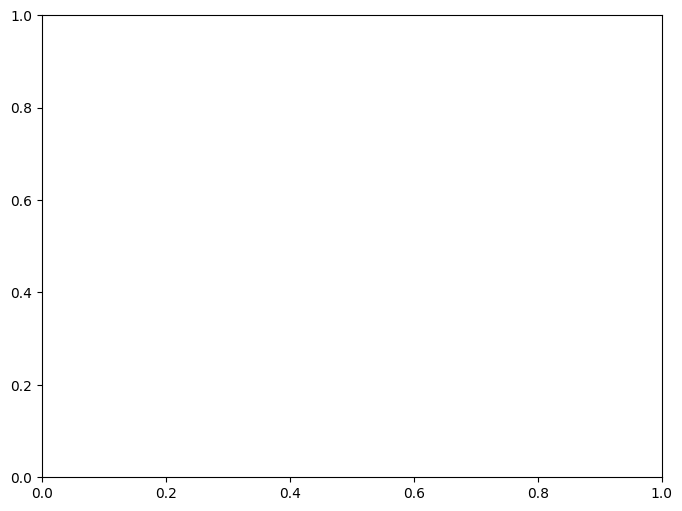

In [29]:
# Plotting the cost history

print(results)
plt.figure(figsize=(8, 6))  # Optional: Set figure size
plt.plot(np.arange(len(results)), results, marker='o', linestyle='-', color='b', label='Cost History')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost History per Epoch')
plt.legend()

# Display the plot
plt.grid(True)  # Optional: Add grid for better visualization
plt.show()


### Generate initial sampling plan using LHS

In [30]:
x = LHS_sample(N_INITIAL, DIM)
x = torch.from_numpy(x)
x = x.to(torch.float32)

print(x)

tensor([[1.9430e-01, 4.2593e-01, 5.1782e-02, 4.6312e-01, 5.8717e-01, 8.0550e-02,
         1.5808e-01, 5.8954e-01, 7.8010e-01, 1.9546e-01, 2.3346e-01],
        [8.2841e-02, 1.5114e-01, 3.1468e-01, 9.1113e-01, 3.4113e-01, 4.1696e-01,
         7.9716e-01, 6.1551e-01, 2.7567e-01, 6.5553e-01, 3.6470e-01],
        [7.7532e-01, 7.8011e-01, 2.8030e-01, 8.8753e-01, 7.8784e-01, 8.0072e-01,
         4.1388e-01, 4.6969e-01, 8.0851e-01, 7.1225e-01, 7.0907e-01],
        [2.5505e-01, 9.0570e-01, 1.0146e-01, 6.3323e-01, 7.2081e-01, 7.0890e-01,
         8.4508e-01, 3.4561e-01, 6.4246e-01, 2.8280e-01, 3.1336e-01],
        [3.6122e-01, 9.4351e-01, 8.6617e-01, 4.1844e-01, 1.8349e-01, 1.5054e-01,
         6.9903e-01, 3.3672e-01, 9.1184e-01, 8.3811e-01, 4.5799e-01],
        [5.9545e-01, 2.3893e-01, 6.9809e-01, 7.3286e-01, 8.9113e-02, 2.7005e-01,
         9.2525e-02, 2.5443e-01, 7.4815e-01, 6.9045e-01, 8.3212e-01],
        [7.9768e-01, 4.4026e-01, 7.4822e-02, 3.6279e-01, 2.8714e-01, 8.4217e-01,
         9.75

In [ ]:
import os.path

name_f, name_x = 'f.mat', 'x.mat'
path = './'
pathname_f = path + name_f
pathname_x = path + name_x
check_file = os.path.isfile(pathname_f)
if check_file:
    mat_contents = sio.loadmat(pathname_f)
    f = mat_contents['f']
    f = torch.Tensor(f)
    f = f.view(N_INITIAL)
    
    mat_contents = sio.loadmat(pathname_x)
    x = mat_contents['x']
    x = torch.Tensor(x)
else:
    f = obj_fun(x)
    f = f.view(N_INITIAL)
    sio.savemat(name_f, {'f': f.numpy()})
    sio.savemat(name_x, {'x': x.numpy()})

In [32]:
train_x, val_x, train_g, val_g = train_test_split(x, f, test_size=0.20)
# Converter os dados de treino e validação para o tipo float32
train_x = train_x.float()
train_g = train_g.float()
val_x = val_x.float()
val_g = val_g.float()
print(train_x)
print(train_g)
print(val_x)
print(val_g)

tensor([[4.7523e-01, 4.9613e-01, 4.4039e-01, 8.1176e-01, 6.7475e-01, 3.0890e-01,
         3.3439e-01, 9.6833e-01, 1.1303e-01, 9.0864e-01, 1.4212e-01],
        [6.2242e-01, 3.9044e-01, 8.9442e-01, 9.7776e-01, 6.9011e-01, 5.4168e-01,
         9.4090e-01, 2.2104e-01, 8.5142e-01, 5.9993e-01, 5.4071e-01],
        [3.9480e-01, 2.1277e-01, 9.1779e-02, 7.6809e-01, 8.0044e-01, 9.3497e-01,
         2.2434e-01, 8.3753e-01, 3.0085e-01, 5.4775e-01, 8.0024e-01],
        [9.5418e-01, 1.3406e-01, 3.5547e-01, 5.0844e-01, 7.6128e-01, 4.8944e-02,
         1.3649e-01, 3.7623e-01, 3.7755e-01, 7.9599e-01, 6.6079e-01],
        [2.5505e-01, 9.0570e-01, 1.0146e-01, 6.3323e-01, 7.2081e-01, 7.0890e-01,
         8.4508e-01, 3.4561e-01, 6.4246e-01, 2.8280e-01, 3.1336e-01],
        [7.2287e-01, 3.3633e-01, 1.6865e-01, 3.4806e-02, 4.6752e-01, 1.6373e-01,
         2.4288e-01, 1.3924e-01, 2.3009e-01, 3.0666e-01, 4.0134e-01],
        [4.4195e-01, 7.2039e-02, 5.0869e-01, 1.7707e-01, 1.7595e-01, 1.2159e-02,
         7.51

## Efficient Global Optimization

In [ ]:
model, likelihood, best_loss = train_model(train_x, train_g, val_x, val_g, TRAINING_ITERATIONS)
model.eval()
likelihood.eval()
it = 0
print(f'\nIteration {it}. Best of DGPR: {torch.min(f)}. GPR model: Train loss = {best_loss[0]}; Val. loss = {best_loss[-1]}')

In [ ]:
while it < N_INFILL:
    it += 1
    
    # Search for the maximum expected improvement
    new_point = bsa(expected_improvement, bounds=BOUNDS_BSA,
                    popsize=BSA_POPSIZE, epoch=BSA_EPOCH, data=model)
    x_new = torch.from_numpy(new_point.x).float()  # Garantir que x_new esteja em float
    EI = new_point.y

    # Objective function at the new point
    f_new = obj_fun(x_new.unsqueeze(0).float())  # Garante que x_new é float32 e 1D
    f_new = f_new.view(-1)                       # Ajusta f_new para a concatenação com f

    print(f'Iteration {it} of {N_INFILL}')
    if f_new.item() < torch.min(f).item():       # Converte f_new e torch.min(f) para escalares
        print(f'New best: {float(f_new):.2f} at position {it}')
    
    # Add new values to the initial sampling
    x = torch.cat((x, x_new.unsqueeze(0)), 0).float()
    f = torch.cat((f, f_new), 0).float()
    
    # Update model
    train_x, val_x, train_g, val_g = train_test_split(x.float(), f.float(), test_size=0.20)
    model, likelihood, best_loss = train_model(train_x, train_g, val_x, val_g, TRAINING_ITERATIONS)
    model = model.to(torch.float32)
    likelihood = likelihood.to(torch.float32)
    model.eval()
    likelihood.eval()
    
    print(f'\nIteration {it}. Best of DGPR: {torch.min(f)}. GPR model: Train loss = {best_loss[0]}; Val. loss = {best_loss[-1]}')
    
    # if abs(EI) < TOL_MIN_EI:
    #     print('Optimization finished. Minimum tolerance achieved.')
    #     break


In [35]:
print(f'f*: {torch.min(f):.2f}; x*: {x[torch.argmin(f), :]}')


f*: -0.01; x*: tensor([0.7112, 0.5832, 0.4959, 0.0000, 0.2557, 0.5528, 0.2021, 0.2864, 0.0493,
        1.0000, 0.1709])


### Save results

In [36]:
results = dict()
results["x"] = x
results["f"] = f
results["n_initial"] = N_INITIAL
results["n_infill"] = N_INFILL
results["OFEs"] = N_INITIAL + it

In [37]:
name_f, name_x = 'f.mat', 'x.mat'
path = './'
pathname_f = path + name_f
pathname_x = path + name_x

sio.savemat(name_f, {'f': f.numpy()})
sio.savemat(name_x, {'x': x.numpy()})

### Plot optimization history

In [38]:
# Plotting the cost history
plt.figure(figsize=(8, 6))  # Optional: Set figure size
plt.plot(np.arange(EPOCHS), results.convergence, marker='o', linestyle='-', color='b', label='Cost History')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost History per Epoch')
plt.legend()

# Display the plot
plt.grid(True)  # Optional: Add grid for better visualization
plt.show()

AttributeError: 'dict' object has no attribute 'convergence'

<Figure size 800x600 with 0 Axes>

In [1]:
#Sair da port do mapdl e fechar o processo
mapdl.exit()

NameError: name 'mapdl' is not defined